The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# AutoRec: Previsão de classificação com codificadores automáticos

Embora o modelo de fatoração de matriz alcance um desempenho decente na tarefa de previsão de classificação, é essencialmente um modelo linear. Portanto, esses modelos não são capazes de capturar relacionamentos não lineares complexos e intrincados que podem ser preditivos das preferências dos usuários. Nesta seção, apresentamos um modelo de filtragem colaborativa de rede neural não linear, AutoRec :cite:`Sedhain.Menon.Sanner.ea.2015`. Ele identifica a filtragem colaborativa (CF) com uma arquitetura autoencoder e visa integrar transformações não lineares em CF com base no feedback explícito. As redes neurais têm se mostrado capazes de aproximar qualquer função contínua, tornando-as adequadas para lidar com a limitação da fatoração da matriz e enriquecer a expressividade da fatoração da matriz.

Por um lado, o AutoRec tem a mesma estrutura de um autoencoder, que consiste em uma camada de entrada, uma camada oculta e uma camada de reconstrução (saída). Um autoencoder é uma rede neural que aprende a copiar sua entrada para sua saída, a fim de codificar as entradas nas representações ocultas (e geralmente de baixa dimensão). No AutoRec, em vez de incorporar explicitamente usuários / itens em um espaço de baixa dimensão, ele usa a coluna / linha da matriz de interação como entrada e, a seguir, reconstrói a matriz de interação na camada de saída.

Por outro lado, o AutoRec difere de um autoencoder tradicional: em vez de aprender as representações ocultas, o AutoRec se concentra em aprender / reconstruir a camada de saída. Ele usa uma matriz de interação parcialmente observada como entrada, com o objetivo de reconstruir uma matriz de classificação completa. Nesse ínterim, as entradas ausentes da entrada são preenchidas na camada de saída por meio da reconstrução para fins de recomendação.

Existem duas variantes do AutoRec: baseado no usuário e baseado no item. Para resumir, aqui apresentamos apenas o AutoRec baseado em item. O AutoRec baseado no usuário pode ser derivado de acordo.


## Modelo

Deixe $\mathbf{R}_{*i}$ denotar a coluna $i^\mathrm{th}$ da matriz de classificação, onde classificações desconhecidas são definidas como zeros por padrão. A arquitetura neural é definida como:

$$
h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)
$$

onde $f(\cdot)$ e $g(\cdot)$ representam funções de ativação, $\mathbf{W}$ e $\mathbf{V}$ são matrizes de peso, $\mu$ e $b$ são vieses. Deixe $h( \cdot )$ denotar toda a rede do AutoRec. A saída $h(\mathbf{R}_{*i})$ é a reconstrução da coluna $i^\mathrm{th}$ da matriz de classificação.

A seguinte função objetivo visa minimizar o erro de reconstrução:

$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

onde $\| \cdot \|_{\mathcal{O}}$ significa que apenas a contribuição das classificações observadas é considerada, ou seja, apenas os pesos que estão associados às entradas observadas são atualizados durante a retropropagação.


In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementando o Modelo

Um autoencoder típico consiste em um codificador e um decodificador. O codificador projeta a entrada para representações ocultas e o decodificador mapeia a camada oculta para a camada de reconstrução. Seguimos essa prática e criamos o codificador e o decodificador com camadas densas. A ativação do codificador é definida como `sigmóide` por padrão e nenhuma ativação é aplicada para o decodificador. O dropout é incluído após a transformação da codificação para reduzir o sobreajuste. Os gradientes de entradas não observadas são mascarados para garantir que apenas as classificações observadas contribuam para o processo de aprendizagem do modelo.


In [2]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred

## Reimplementando o avaliador

Como a entrada e a saída foram alteradas, precisamos reimplementar a função de avaliação, enquanto ainda usamos o RMSE como medida de precisão.


In [3]:
def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

## Treinamento e avaliação do modelo

Agora, vamos treinar e avaliar o AutoRec no conjunto de dados MovieLens. Podemos ver claramente que o teste RMSE é inferior ao modelo de fatoração de matriz, confirmando a eficácia das redes neurais na tarefa de previsão de classificação.


train loss 0.000, test RMSE 0.898
37361958.6 examples/sec on [gpu(0), gpu(1)]


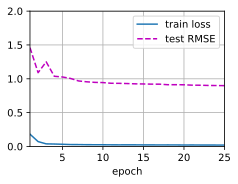

In [4]:
devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)

## Sumário

* Podemos enquadrar o algoritmo de fatoração de matriz com codificadores automáticos, integrando camadas não lineares e regularização de dropout.
* Experimentos no conjunto de dados MovieLens 100K mostram que o AutoRec atinge um desempenho superior do que a fatoração de matriz.

## Exercícios

* Varie a dimensão oculta do AutoRec para ver seu impacto no desempenho do modelo.
* Tente adicionar mais camadas ocultas. É útil melhorar o desempenho do modelo?
* Você consegue encontrar uma combinação melhor de decodificador e funções de ativação do codificador?


[Discussions](https://discuss.d2l.ai/t/401)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTA1MjA3Mjc4N119
-->
